# Segmentation of Indian Traffic

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
from tqdm import tqdm_notebook

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    l1=[]
    l2=[]
    path=os.path.join(root_dir,"images")
    path1=os.path.join(root_dir,"mask")
    for item in tqdm_notebook(os.listdir(path)):
        for file in os.listdir(os.path.join(path,item)):
            l1.append(os.path.join(path,item,file))
    
    for item in tqdm_notebook(os.listdir(path1)):
        for file in os.listdir(os.path.join(path1,item)):
            l2.append(os.path.join(path1,item,file))
    
    data_df = pd.DataFrame(list(zip(l1, l2)), 
               columns =['image', 'json']) 
    return data_df

In [ ]:
data_df = return_file_names_df("data")
data_df.head()

S:\ana\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


S:\ana\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


,image,json
0,data\images\201\frame0029_leftImg8bit.jpg,data\mask\201\frame0029_gtFine_polygons.json
1,data\images\201\frame0299_leftImg8bit.jpg,data\mask\201\frame0299_gtFine_polygons.json
2,data\images\201\frame0779_leftImg8bit.jpg,data\mask\201\frame0779_gtFine_polygons.json
3,data\images\201\frame1019_leftImg8bit.jpg,data\mask\201\frame1019_gtFine_polygons.json
4,data\images\201\frame1469_leftImg8bit.jpg,data\mask\201\frame1469_gtFine_polygons.json


In [ ]:
data_df.shape

(4008, 2)

#### Compute the unique labels

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels=[]
    for item in tqdm_notebook(data_df.values):
        #print(item[1])
        f=open(item[1],) 
        data = json.load(f)
        for i in range (0,len(data['objects'])):
            unique_labels.append(data['objects'][i]['label'])
        unique_labels=list(set(unique_labels))
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

S:\ana\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image

    
    # width of the image
    # height of the image
    f=open(file)
    file = json.load(f) 
    #print(file['objects'][0])
    label=[]
    vertexlist=[]
    for item in file['objects']:
        #print(item)
        label.append(item['label'])
        
        vertexlist.append([tuple(x) for x in item['polygon']])
    h=file['imgHeight']
    w=file['imgWidth']
    #print(len(set(label)))
    #print(h,w)
    f.close()
    return (w, h, label, vertexlist)

## 4. Creating Image segmentations by drawing set of polygons

In [ ]:
os.mkdir("data/output")
for i in range(201,430):
    os.mkdir("data/output/"+str(i))

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    result_path="data/output"
    l=[]
    for item in tqdm_notebook(data_df.values[:,1]):
        
        w, h, labels, vertexlist = get_poly(item)
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for i in range(0,len(labels)):
            if len(vertexlist[i])>1:
                img1.polygon(vertexlist[i], fill = label_clr[labels[i]])

        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        im.save(os.path.join(result_path,item[10:-5])+".png")
        l.append(os.path.join(result_path,item[10:-5])+".png")
    data_df['mask']=l

    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

S:\ana\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


,image,json,mask
0,data\images\201\frame0029_leftImg8bit.jpg,data\mask\201\frame0029_gtFine_polygons.json,data/output\201\frame0029_gtFine_polygons.png
1,data\images\201\frame0299_leftImg8bit.jpg,data\mask\201\frame0299_gtFine_polygons.json,data/output\201\frame0299_gtFine_polygons.png
2,data\images\201\frame0779_leftImg8bit.jpg,data\mask\201\frame0779_gtFine_polygons.json,data/output\201\frame0779_gtFine_polygons.png
3,data\images\201\frame1019_leftImg8bit.jpg,data\mask\201\frame1019_gtFine_polygons.json,data/output\201\frame1019_gtFine_polygons.png
4,data\images\201\frame1469_leftImg8bit.jpg,data\mask\201\frame1469_gtFine_polygons.json,data/output\201\frame1469_gtFine_polygons.png


###### PART 1: DATA PREPROCESSING

 Here we are creating the following directory structure so to fead into data pipeline:

 data_new----> train,trainannot,test,testannot.

 train and test directory has images of train set and test set in .jpg format

 trainannot and testannot has masks of train set and test set in .png format 

In [ ]:
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm_notebook
import os

In [ ]:
os.mkdir("data_new")
os.mkdir("data_new/train")
os.mkdir("data_new/trainannot")
os.mkdir("data_new/test")
os.mkdir("data_new/testannot")

In [ ]:
df=pd.read_csv("preprocessed_data.csv")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df["image"].values, df["mask"].values, test_size=0.2, random_state=42)

In [ ]:
target1="data_new/train"
target2="data_new/trainannot"

i=1
for item1,item2 in tqdm_notebook(zip(x_train,y_train)):
    shutil.copyfile(item1, os.path.join(target1,"image"+str(i)+".jpg"))
    shutil.copyfile(item2, os.path.join(target2, "mask"+str(i)+".png"))
    i+=1

S:\ana\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
target1="data_new/test"
target2="data_new/testannot"

i=1
for item1,item2 in tqdm_notebook(zip(x_test,y_test)):
    shutil.copyfile(item1, os.path.join(target1,"image"+str(i)+".jpg"))
    shutil.copyfile(item2, os.path.join(target2, "mask"+str(i)+".png"))
    i+=1

S:\ana\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
len(x_train),len(os.listdir("data_new/train/"))

(3206, 3206)

In [ ]:
len(y_train),len(os.listdir("data_new/trainannot/"))

(3206, 3206)

In [ ]:
len(x_test),len(os.listdir("data_new/test/"))

(802, 802)

In [ ]:
len(y_test),len(os.listdir("data_new/testannot/"))

(802, 802)

#### PART 2: BUILDING THE UNET

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
! unzip "gdrive/My Drive/data_new.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data_new/train/image2994.jpg  
  inflating: data_new/train/image2995.jpg  
  inflating: data_new/train/image2996.jpg  
  inflating: data_new/train/image2997.jpg  
  inflating: data_new/train/image2998.jpg  
  inflating: data_new/train/image2999.jpg  
  inflating: data_new/train/image3.jpg  
  inflating: data_new/train/image30.jpg  
  inflating: data_new/train/image300.jpg  
  inflating: data_new/train/image3000.jpg  
  inflating: data_new/train/image3001.jpg  
  inflating: data_new/train/image3002.jpg  
  inflating: data_new/train/image3003.jpg  
  inflating: data_new/train/image3004.jpg  
  inflating: data_new/train/image3005.jpg  
  inflating: data_new/train/image3006.jpg  
  inflating: data_new/train/image3007.jpg  
  inflating: data_new/train/image3008.jpg  
  inflating: data_new/train/image3009.jpg  
  inflating: data_new/train/image301.jpg  
  inflating: data_new/train/image3010.jpg  
  inflating: data_new/train/imag

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import tensorflow as tf

In [ ]:
x_train_dir = os.path.join("data_new", 'train')
y_train_dir = os.path.join("data_new", 'trainannot')
x_test_dir= os.path.join("data_new", 'test')
y_test_dir= os.path.join("data_new", 'testannot')

In [ ]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.GaussianBlur(sigma=(0, 3.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = [0,1,2,3,4,5,6,7,8,9
               ,10,11,12,13,14,15,16,17,18,19,20]
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            is_training=None,
            classes=None, 

    ):
        self.id = os.listdir(images_dir)
       # print(self.id)
        
        self.images_fps = [os.path.join(images_dir, image_id1) for image_id1 in self.id]
        self.masks_fps = [os.path.join(masks_dir, image_id2[:-4])+".png" for image_id2 in self.id]
        self.is_training=is_training
        #print(self.masks_fps)
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
        

    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i],cv2.IMREAD_UNCHANGED)
        image=cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image_mask = cv2.imread(self.masks_fps[i],0)
        image_mask = cv2.resize(image_mask, (256, 256),  interpolation = cv2.INTER_AREA)
        image_mask=image_mask/10
        #print(image.shape,image_mask.shape)
        #print(self.id)
        #print(self.images_fps[i])
        #print(self.masks_fps[i])
        
        # extract certain classes from mask (e.g. cars)
        masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(masks, axis=-1).astype('float')

        if self.is_training==True:
      
          a = np.random.uniform()
          #print(a)
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask
          else:
              image = aug6.augment_image(image)
              image_mask = aug6.augment_image(image_mask) 
        
        return image, image_mask
        
    def __len__(self):
        return len(self.id)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
    
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

Below we are just viewing the image and 2 masks for a random datapoint just as sanity check

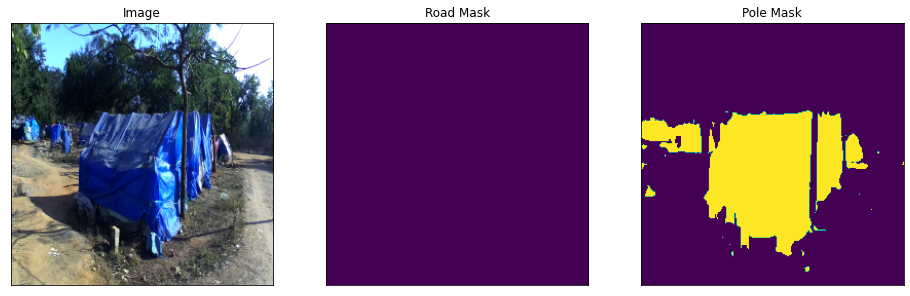

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir,is_training=False, classes=[1, 13])

image, mask = dataset[566] # get some sample
visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    pole_mask=mask[..., 1].squeeze(),
    
)

In [ ]:
!pip install -U segmentation-models

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models.metrics import iou_score
#sm.set_framework("tf.keras")

BACKBONE = 'densenet169'
BATCH_SIZE = 8
CLASSES = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
LR = 0.0001
EPOCHS = 50

tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

In [ ]:
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,input_shape=(256,256,3), encoder_freeze=True,decoder_block_type='transpose')

51879936/51877672 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
optim = tf.keras.optimizers.Adam(LR)
focal_loss = sm.losses.cce_dice_loss
model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:

train_dataset = Dataset(x_train_dir,y_train_dir,is_training=True, classes=CLASSES)
test_dataset  = Dataset(x_test_dir,y_test_dir,is_training=False, classes=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes) 

c = [
    tf.keras.callbacks.ModelCheckpoint('./gdrive/My Drive/seg.h5', save_weights_only=True, save_best_only=True, \
                                      mode='max', monitor='val_iou_score',verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=4,mode='max'),
    
]


(8, 256, 256, 3)


In [ ]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=EPOCHS,validation_data=test_dataloader,callbacks=c )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
450/450 [==============================] - ETA: 0s - loss: 0.9446 - iou_score: 0.0965
Epoch 00001: val_iou_score improved from -inf to 0.14058, saving model to ./gdrive/My Drive/seg.h5
450/450 [==============================] - 340s 756ms/step - loss: 0.9446 - iou_score: 0.0965 - val_loss: 0.8563 - val_iou_score: 0.1406 - lr: 1.0000e-04
Epoch 2/50
450/450 [==============================] - ETA: 0s - loss: 0.7937 - iou_score: 0.1930
Epoch 00002: val_iou_score improved from 0.14058 to 0.20027, saving model to ./gdrive/My Drive/seg.h5
450/450 [==============================] - 330s 733ms/step - loss: 0.7937 - iou_score: 0.1930 - val_loss: 0.7662 - val_iou_score: 0.2003 - lr: 1.0000e-04
Epoch 3/50
450/450 [==============================] - ETA: 0s - loss: 0.6871 - iou_score: 0.2712
Epoch 00003: val_iou_score improved from 0.20027 to 0.27863, saving model to ./gdrive/My Drive/seg.h5
450/450 [=============

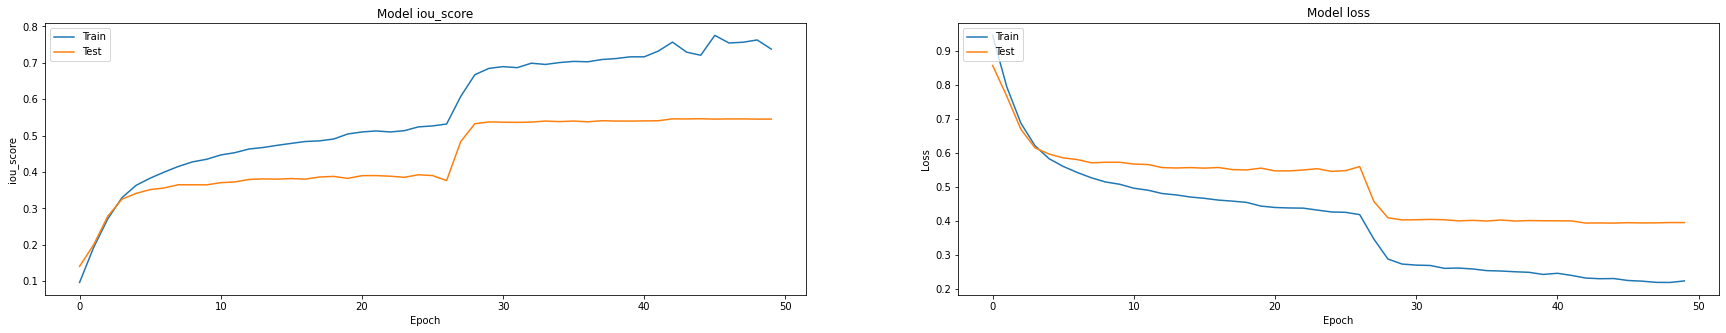

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('./gdrive/My Drive/seg.h5')

In [ ]:
id = os.listdir(x_test_dir)
images_fps = [os.path.join(x_test_dir, image_id1) for image_id1 in id]
masks_fps = [os.path.join(y_test_dir, image_id2[:-4])+".png" for image_id2 in id]

1/1 [==============================] - 0s 1ms/step


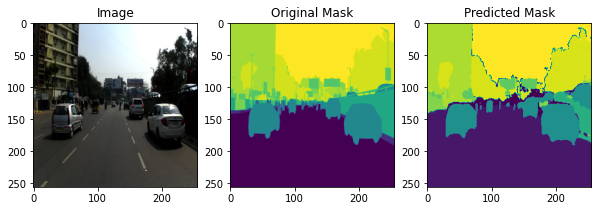

1/1 [==============================] - 0s 898us/step


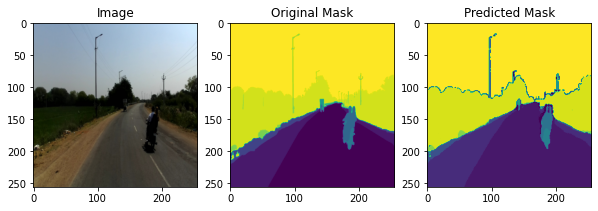

1/1 [==============================] - 0s 927us/step


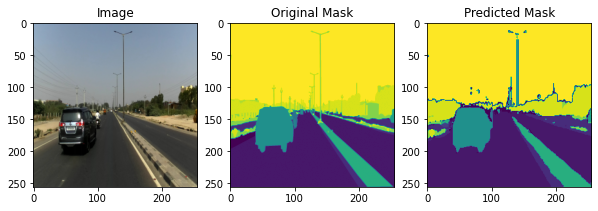

1/1 [==============================] - 0s 951us/step


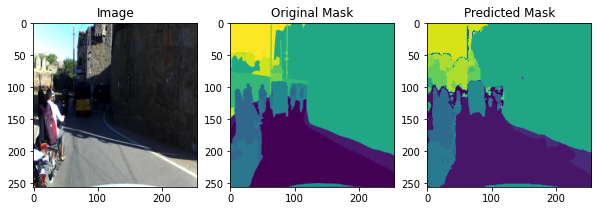

1/1 [==============================] - 0s 947us/step


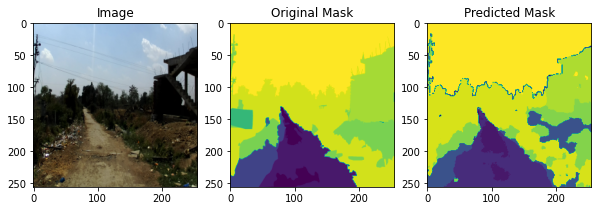

1/1 [==============================] - 0s 933us/step


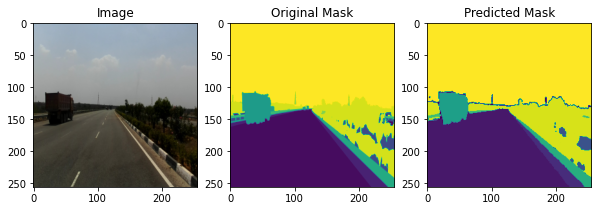

1/1 [==============================] - 0s 954us/step


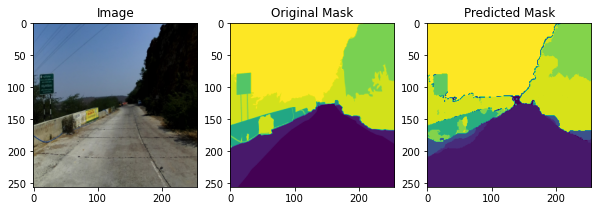

1/1 [==============================] - 0s 1ms/step


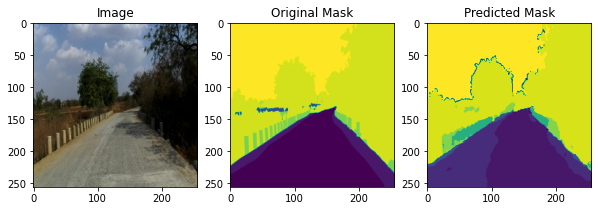

1/1 [==============================] - 0s 1ms/step


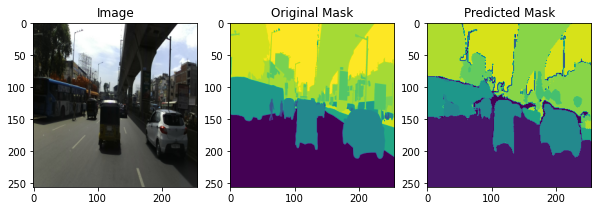

1/1 [==============================] - 0s 974us/step


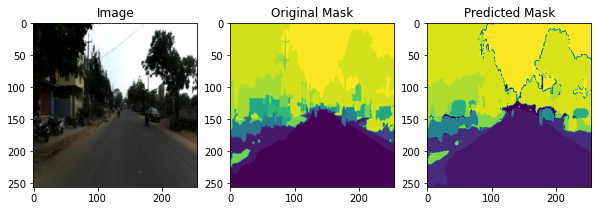

1/1 [==============================] - 0s 949us/step


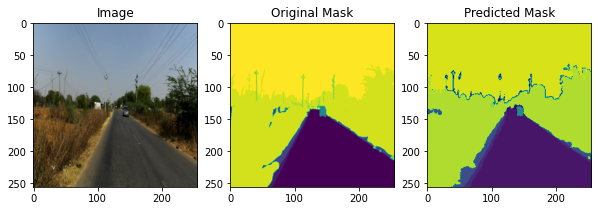

1/1 [==============================] - 0s 895us/step


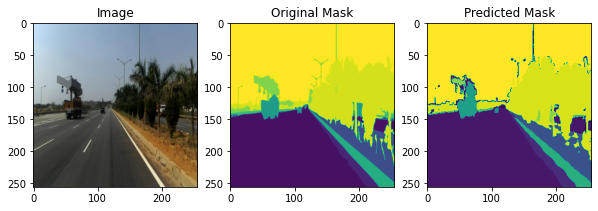

1/1 [==============================] - 0s 1ms/step


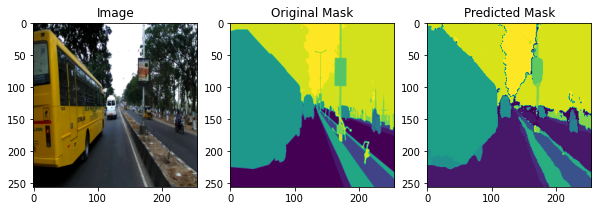

1/1 [==============================] - 0s 885us/step


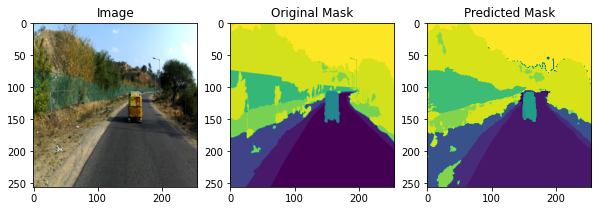

1/1 [==============================] - 0s 863us/step


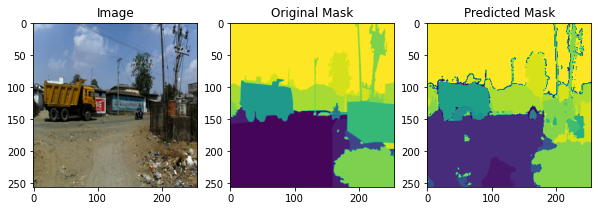

In [ ]:
n = 15
ids = np.random.choice(np.arange(len(test_dataset)), size=n,replace=False)
for i in ids:
  image = cv2.imread(images_fps[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA) 
  image = np.expand_dims(image, axis=0)
  image_mask = cv2.imread(masks_fps[i],0)

  image_mask = cv2.resize(image_mask, (256, 256),  interpolation = cv2.INTER_AREA)
  image_mask=image_mask/10
  pred=model.predict(image,verbose=1)
  pred = tf.argmax(pred, axis=-1)

  fig = plt.figure(figsize=(10,6))
  #plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(131)
  ax1.imshow(image[0,:,:])
  ax2=fig.add_subplot(132)
  ax2.imshow(image_mask)
  ax3=fig.add_subplot(133)
  ax3.imshow(pred[0,:,:])
  ax1.title.set_text('Image')
  ax2.title.set_text('Original Mask')
  ax3.title.set_text('Predicted Mask')
  plt.show()
